## Regression Outline
We have a set of manually categorized FERC plants with which to test the sklearn Classifier that we're making. We'll also use them to test the regression analysis here. What does this dataset look like, how was it created?
* Pull FERC Plants table.
* Using a variety of search methods, to ensure that we get a wide variety of plants, identify sets of records in the FERC Form 1 Plants table that are comparable inter-year records.


For regressions, both OLS and sklearn approaches are explored.  Plant generation is normalized by using capacity factor.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np

import scipy
import pandas as pd
import statsmodels.api as sm
import sklearn
from sklearn import linear_model
from pudl import init, analysis, settings, output
import pudl.extract.ferc1
import pudl.transform.ferc1
import pudl.constants as pc
import pudl.output.pudltabl
import pudl.analysis.analysis
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

In [3]:
# For some reason these things don't stick if they're in the same cell as the
# %matplotlib inline call above, but if they're separate, they work fine.
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = (10,6)
mpl.rcParams['figure.dpi'] = 150
pd.options.display.max_columns = 56

In [4]:
pudl_out = pudl.output.pudltabl.PudlTabl()
ferc1_fuel = pudl_out.fuel_ferc1()
ferc1_steam = pudl_out.plants_steam_ferc1()

In [5]:
def ferc1_aggregate_by_fuel_type(df, fuels = ['gas', 'oil', 'coal']):
    ''' 
    Aggregate FERC 1 data by fuel type and plant per year.
    
    Inputs: 
    df is cleaned FERC 1 fuel table
    fuels is list of fuels of interest to aggregate
    
    Returns dataframe of aggregated fuel consumed and fuel costs'''
    
    fuel_df = df[df['fuel_type_code_pudl'].isin(fuels)]
    
    # We have two different ways of assessing the total cost of fuel given cost
    # per unit delivered and cost per mmbtu. They *should* be the same, but we
    # know they aren't always. Calculate both so we can compare both.
    fuel_df['fuel_consumed_total_mmbtu'] = \
        fuel_df['fuel_qty_burned'] * fuel_df['fuel_mmbtu_per_unit'] # same as total heat content
    fuel_df['fuel_consumed_total_cost_mmbtu'] = \
        fuel_df['fuel_cost_per_mmbtu'] * fuel_df['fuel_consumed_total_mmbtu']
    fuel_df['fuel_consumed_total_cost_unit'] = \
        fuel_df['fuel_cost_per_unit_burned'] * fuel_df['fuel_qty_burned']


    # Group by fuel as well, so we get individual fuel totals.
    cols_to_gb = ['plant_id_ferc1', 'report_year', 'fuel_type_code_pudl']
    cols=['fuel_consumed_total_mmbtu',
                                 'fuel_consumed_total_cost_mmbtu',
                                 'fuel_consumed_total_cost_unit']

    fuel_df = fuel_df.groupby(cols_to_gb)[cols].sum()
    fuel_df = fuel_df.reset_index()
    
    # Group by plant, so we get total fuel use/cost.
    cols_to_gb = ['plant_id_ferc1', 'report_year']
    cols=['fuel_consumed_total_mmbtu',
                                 'fuel_consumed_total_cost_mmbtu',
                                 'fuel_consumed_total_cost_unit'] 


    fuel_df_plant = fuel_df.groupby(cols_to_gb)[cols].sum()
    fuel_df_plant = fuel_df_plant.reset_index()
    
    return fuel_df_plant

In [6]:
fuel_df_plant = ferc1_aggregate_by_fuel_type(ferc1_fuel)

/home/alana/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/alana/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/alana/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.p

In [7]:
# diff = fuel_df_plant.fuel_consumed_total_cost_mmbtu - fuel_df_plant.fuel_consumed_total_cost_unit
# Max difference in costs is on the order of 1e+9; median is 4e-1; 
# Could use this calculation comparison to eliminate, or further investigate, outliers.

In [8]:
out_df = pd.merge(fuel_df_plant, ferc1_steam, on=['plant_id_ferc1', 'report_year'])
out_df["heat_rate"] = (out_df.fuel_consumed_total_mmbtu / out_df.net_generation_mwh)
out_df['capacity_factor'] = (out_df['net_generation_mwh']/ (out_df['capacity_mw']*8760))

first_cols = [
    'report_year',
    'utility_id_ferc1',
    'plant_id_ferc1',
    'plant_name'
]

out_df = pudl.helpers.organize_cols(out_df, first_cols)

In [9]:
# Check to see if the 'tot_prdctn_expns' is equivalent to the non-fuel costs by summing non-fuel values
out_df["all_costs"] = (out_df.opex_allowances+out_df.opex_boiler+
                                  out_df.opex_coolants+
                         out_df.opex_electric+out_df.opex_engineering+
                                  out_df.opex_fuel+out_df.opex_misc_power+
                                  out_df.opex_misc_steam+
                        out_df.opex_operations+out_df.opex_plants+
                                  out_df.opex_rents+
                        out_df.opex_steam+out_df.opex_steam_other+
                                  out_df.opex_structures+
                        out_df.opex_transfer)

In [10]:
# Check to see if for all records the 'tot_prdctn_expns' approximately equals the sum from 'all_costs'
out_df['result'] = out_df['all_costs'].ge(out_df['opex_production_total']) | np.isclose(out_df['all_costs'], out_df['opex_production_total'], rtol=1e+1)

In [11]:
out_df.result.describe() # For all records, the costs are within $10. Confirms 'tot_prdctn_expsn' is all non-fuel costs

count     10552
unique        1
top        True
freq      10552
Name: result, dtype: object

In [12]:
# No need to retain these - have confirmed that 'opex_production_total' is sum of all other costs
out_df.drop(columns=['result','all_costs'], inplace=True)

In [13]:
# We can get non-fuel by subtracting opex_fuel
out_df['non_fuel_costs'] = (out_df.opex_production_total - out_df.opex_fuel)

In [14]:
out_df.installation_year = pd.to_numeric(out_df.installation_year, errors='coerce')
out_df.construction_year = pd.to_numeric(out_df.construction_year, errors='coerce')

In [15]:
# What types of fuel are included in the training data set?
out_df.plant_type.unique()

array(['steam', 'combustion_turbine', None, 'internal_combustion',
       'nuclear', 'combined_cycle', 'photovoltaic'], dtype=object)

In [16]:
# All records
out_df_s = out_df[(out_df['plant_type'] == 'steam')]
# out_df_ct = out_df[(out_df['plant_type'] == 'combustion_turbine')] 
# out_df_cc = out_df[(out_df['plant_type'] == 'combined_cycle')] 
# out_df_ic = out_df[(out_df['plant_type'] == 'internal_combustion')]
# out_df_n = out_df[(out_df['plant_type'] == 'nuclear')] 
# out_df_pv = out_df[(out_df['plant_type'] == 'photovoltaic')] 

In [17]:
# Unique plants
steam_plants = out_df_s.sort_values('installation_year').drop_duplicates(subset=['capacity_mw', 'plant_name'], keep='last') # 1007 'plants'
# ct = out_df_ct.sort_values('installation_year').drop_duplicates(subset=['plant_id_ferc1'], keep='last') # 584 'plants'
# cc = out_df_cc.sort_values('installation_year').drop_duplicates(subset=['plant_id_ferc1'], keep='last') # 188 'plants'
# ic = out_df_ic.sort_values('installation_year').drop_duplicates(subset=['plant_id_ferc1'], keep='last') # 147 'plants'
# nuc = out_df_n.sort_values('installation_year').drop_duplicates(subset=['plant_id_ferc1'], keep='last') # 5 'plants'
# pv = out_df_pv.sort_values('installation_year').drop_duplicates(subset=['plant_id_ferc1'], keep='last') # 3 'plants'


In [18]:
# Remove null values for variables of interest, for purposes of histogram plotting
steam_plants = steam_plants[steam_plants.construction_year.notnull()]
steam_plants = steam_plants[steam_plants.installation_year.notnull()]
steam_plants = steam_plants[steam_plants.capacity_mw.notnull()]
steam_plants = steam_plants[steam_plants.heat_rate.notnull()]

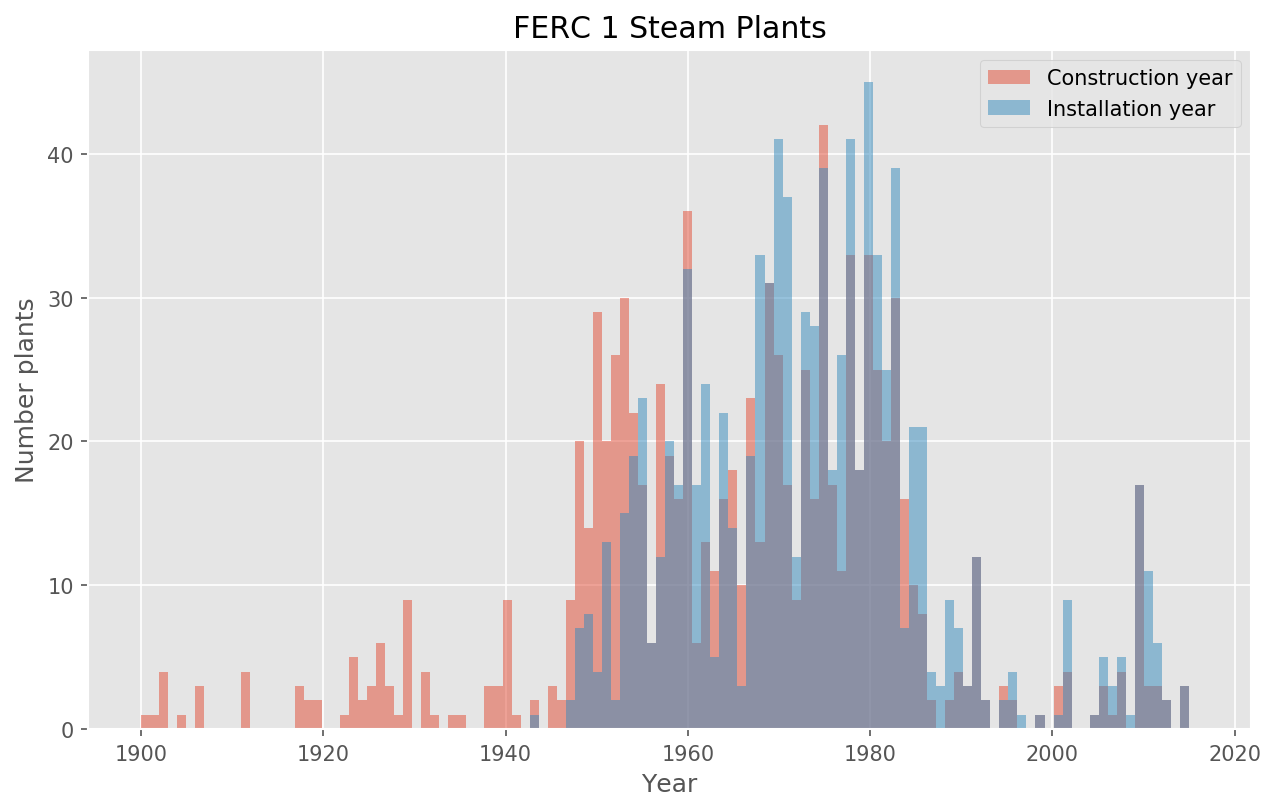

In [19]:
# Look at distribution of construction years vs. installation years.
fig = plt.figure()

plt.xlabel('Year')
plt.ylabel('Number plants')
plt.title('FERC 1 Steam Plants')

mpl.pyplot.hist(steam_plants.construction_year, bins = 117, range = [1900,2016], alpha=0.5, label='Construction year')
mpl.pyplot.hist(steam_plants.installation_year, bins = 117, range = [1900,2016], alpha=0.5, label='Installation year')
mpl.pyplot.legend(loc='upper right');

In [20]:
# fig = plt.figure()
# # ax1 = fig.add_axes([0.1, 0.5, 0.8, 0.4],
# #                    xticklabels=[], ylim=(-1.2, 1.2))
# plt.xlabel('Year')
# plt.ylabel('Number of plants')
# plt.title('FERC 1 Combustion Turbine Plants')

# mpl.pyplot.hist(ct.construction_year, bins = 117, range = [1900,2016], alpha=0.5, label='Construction year')
# mpl.pyplot.hist(ct.installation_year, bins = 117, range = [1900,2016], alpha=0.5, label='Installation year')
# mpl.pyplot.legend(loc='upper left');

In [21]:
# fig = plt.figure()
# # ax1 = fig.add_axes([0.1, 0.5, 0.8, 0.4],
# #                    xticklabels=[], ylim=(-1.2, 1.2))
# plt.xlabel('Year')
# plt.ylabel('Number of plants')
# plt.title('FERC 1 Combined Cycle Plants')

# mpl.pyplot.hist(cc.construction_year, bins = 117, range = [1900,2016], alpha=0.5, label='Construction year')
# mpl.pyplot.hist(cc.installation_year, bins = 117, range = [1900,2016], alpha=0.5, label='Installation year')
# mpl.pyplot.legend(loc='upper left');

In [22]:
# fig = plt.figure()
# # ax1 = fig.add_axes([0.1, 0.5, 0.8, 0.4],
# #                    xticklabels=[], ylim=(-1.2, 1.2))
# plt.xlabel('Year')
# plt.ylabel('Number of plants')
# plt.title('FERC 1 Internal Combustion Plants')

# mpl.pyplot.hist(ic.construction_year, bins = 117, range = [1900,2016], alpha=0.5, label='Construction year')
# mpl.pyplot.hist(ic.installation_year, bins = 117, range = [1900,2016], alpha=0.5, label='Installation year')
# mpl.pyplot.legend(loc='upper left');


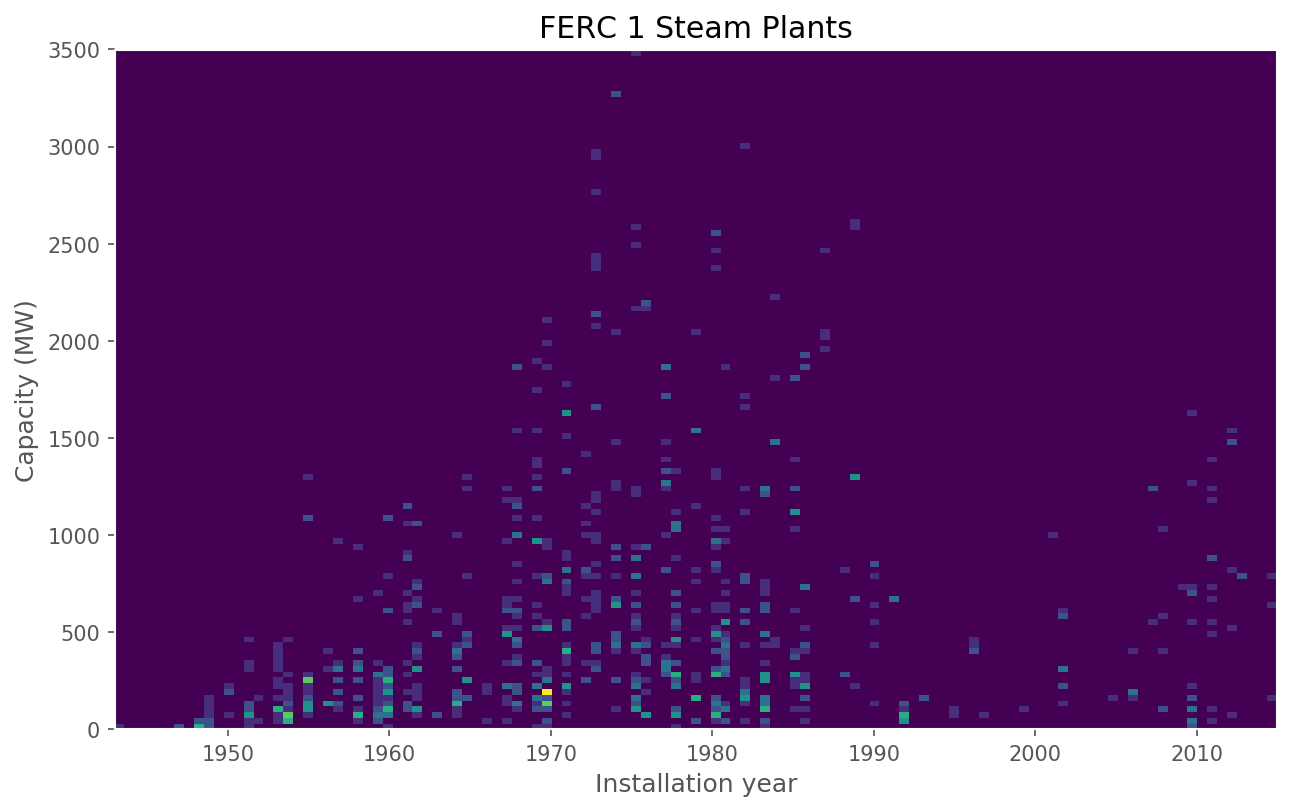

In [23]:
plt.xlabel('Installation year')
plt.ylabel('Capacity (MW)')
plt.title('FERC 1 Steam Plants')
# plt.legend()

mpl.pyplot.hist2d(steam_plants.installation_year, steam_plants.capacity_mw, bins=117);
#1940 and forward, up to 3K megawatts, just steam - natural groupings?
# install, constru, capacity, and HR then we should find groupings to work wtih.

In [24]:
def ferc1_record_subsetting(df, plant_type = 'steam', year_var = 'installation_year', 
                            bin1 = 1970, bin2 = 1987, new_var = 'new_var'):
    """ Subsets records by plant type and vintage. Creates new column for vintage.
    Input variables:
        'old' = year cutoff below which plants are considered 'old'
        'new' = year cutoff above which plants are considered 'new'
        'plant_type' = FERC 1 plant types, including: 'steam', 'combustion_turbine', 'internal_combustion', 'nuclear', 'combined_cycle', 'photovoltaic'
        'year_var' = either 'installation_year' or 'construction_year'
        
        Returns data frame with new column for vintage, and subset to the specified plant types.
        """
    
    out_df = df[(df['plant_type'] == plant_type)]
    out_df.loc[out_df[year_var] <= bin1,new_var] = 1
    out_df.loc[(out_df[year_var] > bin1) & (out_df[year_var] <= bin2), new_var] = 2
    out_df.loc[out_df[year_var] >= bin2, new_var] = 3
#     out_df.new_var = out_df.new_var.as_type(int)

    
    
    return out_df

In [25]:
### Still need to convert 'vintage' to a categorical variable for further use

In [26]:
new = ferc1_record_subsetting(out_df_s, new_var = 'vintage2')

In [27]:
new.head(2)

,report_year,utility_id_ferc1,plant_id_ferc1,plant_name,asset_retirement_cost,avg_num_employees,capacity_factor,capacity_mw,capex_equipment,capex_land,capex_per_mw,capex_structures,capex_total,construction_type,construction_year,fuel_consumed_total_cost_mmbtu,fuel_consumed_total_cost_unit,fuel_consumed_total_mmbtu,heat_rate,id,installation_year,net_generation_mwh,not_water_limited_capacity_mw,opex_allowances,opex_boiler,opex_coolants,opex_electric,opex_engineering,opex_fuel,opex_misc_power,opex_misc_steam,opex_operations,opex_per_mwh,opex_plants,opex_production_total,opex_rents,opex_steam,opex_steam_other,opex_structures,opex_transfer,peak_demand_mw,plant_capability_mw,plant_hours_connected_while_generating,plant_id_pudl,plant_type,record_id,utility_id_pudl,utility_name_ferc1,water_limited_capacity_mw,non_fuel_costs,vintage2
0,2004,1,3,rockport total aeg,740111.0,0.0,0.747678,1300.0,570958171.0,6546500.0,513662.0,89515817.0,667760599.0,conventional,1984.0,1.125020e+08,1.124718e+08,8.284268e+07,9.729537,3,1989.0,8514555.0,1300.0,0.0,7446770.0,0.0,1015690.0,1162047.0,112469856.0,2262724.0,527287.0,1231124.0,23.3,2493261.0,198275299.0,68283913.0,1008109.0,0.0,374518.0,0.0,1337.0,0.0,8360.0,526,steam,2004_1_0_3,7,AEP Generating Company,1300.0,85805443.0,3.0
1,2005,1,3,rockport total aeg,762383.0,0.0,0.787587,1300.0,571875109.0,6546500.0,516365.3,92090920.0,671274912.0,conventional,1984.0,1.400823e+08,1.400792e+08,8.658378e+07,9.653627,1306,1989.0,8969041.0,1300.0,0.0,7714498.0,0.0,1470061.0,1130802.0,140077459.0,2743595.0,646919.0,1903537.0,25.3,1439070.0,227015580.0,68283036.0,1157633.0,0.0,448970.0,0.0,1339.0,0.0,8029.0,526,steam,2005_1_0_3,7,AEP Generating Company,1300.0,86938121.0,3.0


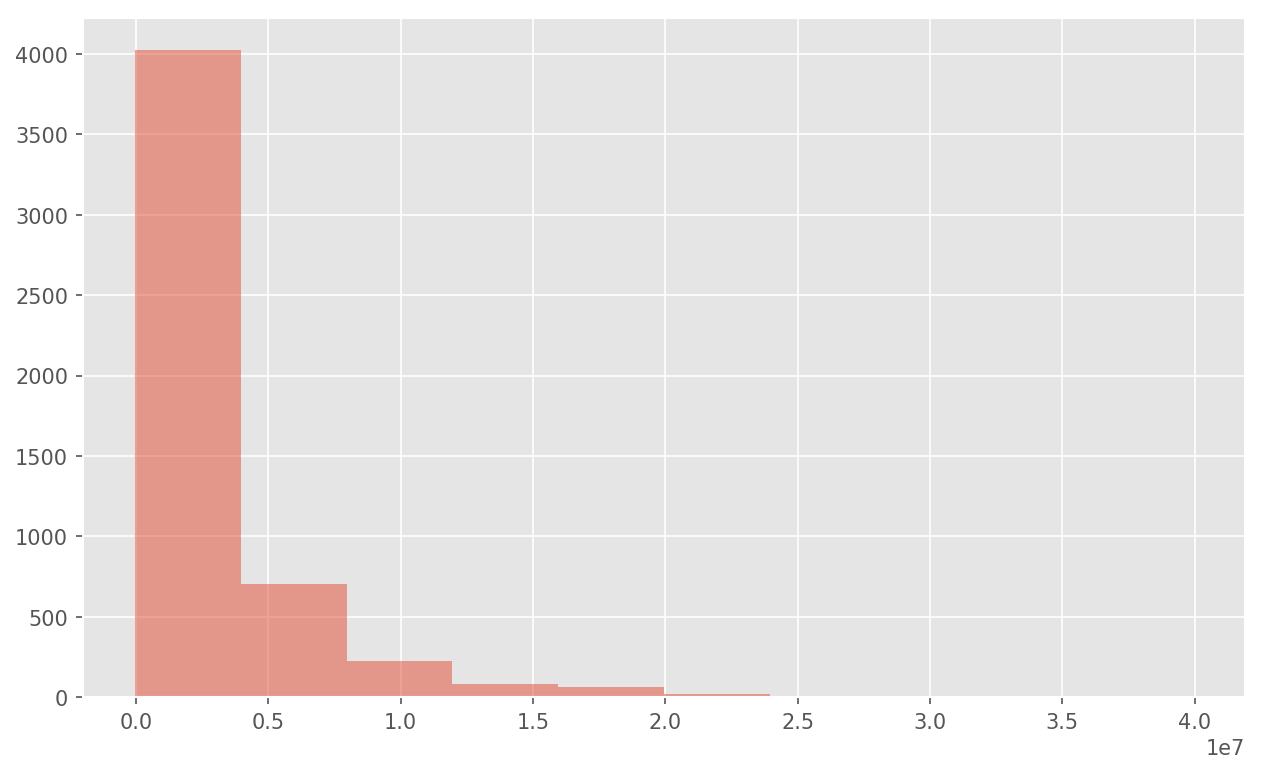

In [28]:
new.net_generation_mwh.hist(alpha=0.5, bins=10)

### Manual binning of construction year, installation year, plant capacity, and net generation

In [29]:
new['construct_bin'] = 0
new.loc[(new['construction_year'] < 1956), 'construct_bin'] = 1
# new.loc[(new['construction_year'] >= 1946) & (new['construction_year']< 1956), 'construct_bin'] = 2
new.loc[(new['construction_year'] >= 1956) & (new['construction_year']< 1966), 'construct_bin'] = 3
new.loc[(new['construction_year'] >= 1966) & (new['construction_year']< 1986), 'construct_bin'] = 4
new.loc[new['construction_year'] >= 1986, 'construct_bin'] = 5
new.construct_bin = new.construct_bin.astype('category')

In [30]:
new['install_bin'] = 0
new.loc[(new['installation_year'] < 1955), 'install_bin'] = 1
# new.loc[(new['installation_year'] >= ) & (new['installation_year']< 1956), 'install_bin'] = 2
new.loc[(new['installation_year'] >= 1955) & (new['installation_year']< 1966), 'install_bin'] = 3
new.loc[(new['installation_year'] >= 1966) & (new['installation_year']< 1986), 'install_bin'] = 4
new.loc[new['installation_year'] >= 1986, 'install_bin'] = 5
new.install_bin = new.install_bin.astype('category')

In [31]:
new['cap_bin'] = 0
new.loc[(new['capacity_mw'] < 500), 'cap_bin'] = 1
new.loc[(new['capacity_mw'] >= 500) & (new['capacity_mw']< 1000), 'cap_bin'] = 2
new.loc[new['capacity_mw'] >= 1000, 'cap_bin'] = 3
new.cap_bin = new.cap_bin.astype('category')

In [32]:
new['net_gen_bin'] = 0
new.loc[(new['net_generation_mwh'] < 1e6), 'net_gen_bin'] = 1
new.loc[(new['net_generation_mwh'] >= 1e6) & (new['net_generation_mwh']< 4e6), 'net_gen_bin'] = 2
new.loc[new['net_generation_mwh'] >= 4e6, 'net_gen_bin'] = 3
new.net_gen_bin = new.net_gen_bin.astype('category')

## Regressions using binned/unbinned fields

In [33]:
# Some variables treated as categorical
res = sm.OLS.from_formula(formula='non_fuel_costs ~ net_generation_mwh + capacity_mw + C(construct_bin) +  C(install_bin)', data=new).fit()
# print(res.params)
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:         non_fuel_costs   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     705.5
Date:                Mon, 04 Feb 2019   Prob (F-statistic):               0.00
Time:                        12:48:36   Log-Likelihood:                -92982.
No. Observations:                5116   AIC:                         1.860e+05
Df Residuals:                    5105   BIC:                         1.861e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              3.014e+

In [34]:
# Some variables treated as categorical
res = sm.OLS.from_formula(formula='non_fuel_costs ~ C(net_gen_bin) + capacity_mw + C(construct_bin) +  C(install_bin)', data=new).fit()
# print(res.params)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         non_fuel_costs   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.558
Method:                 Least Squares   F-statistic:                     588.8
Date:                Mon, 04 Feb 2019   Prob (F-statistic):               0.00
Time:                        12:48:36   Log-Likelihood:                -93106.
No. Observations:                5116   AIC:                         1.862e+05
Df Residuals:                    5104   BIC:                         1.863e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -9.596e+

In [35]:
# Some variables treated as categorical
res = sm.OLS.from_formula(formula='non_fuel_costs ~ net_generation_mwh + C(cap_bin) + C(construct_bin) +  C(install_bin)', data=new).fit()
# print(res.params)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         non_fuel_costs   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     610.7
Date:                Mon, 04 Feb 2019   Prob (F-statistic):               0.00
Time:                        12:48:36   Log-Likelihood:                -93053.
No. Observations:                5116   AIC:                         1.861e+05
Df Residuals:                    5104   BIC:                         1.862e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              2.123e+

In [36]:
# All variables treated as continuous
res = sm.OLS.from_formula('non_fuel_costs ~ capacity_mw + net_generation_mwh + construction_year + installation_year', new).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         non_fuel_costs   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     1638.
Date:                Mon, 04 Feb 2019   Prob (F-statistic):               0.00
Time:                        12:48:36   Log-Likelihood:                -91634.
No. Observations:                5038   AIC:                         1.833e+05
Df Residuals:                    5033   BIC:                         1.833e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -1.633e+08   4.13

# Further/future regression exlorations

In [37]:
# Set up variables for OLS regression 

# X = new[["net_generation_mwh", "heat_rate"]]
X = new[["capacity_mw", "net_generation_mwh"]]
# X = new[["non_fuel_costs"]]
# X = new[["expns_fuel"]]

# y = new["opex_fuel"]
y = new[["non_fuel_costs"]]
# y = new[["net_generation_mwh"]]


X = sm.add_constant(X) ## add an intercept

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

/home/alana/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         non_fuel_costs   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     3189.
Date:                Mon, 04 Feb 2019   Prob (F-statistic):               0.00
Time:                        12:48:36   Log-Likelihood:                -93130.
No. Observations:                5116   AIC:                         1.863e+05
Df Residuals:                    5113   BIC:                         1.863e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.251e+06   3.83e+05      3.270      0.001    5.01e+05       2e+06
capacity_mw         1.734e+04    829.941     20.890      0.000    1.57e+04     1.9e+04
net_generation_mwh     3.3941      0.146     23.203      0.000       3.107       3.681
==============================================================================
Omnibus:                     6565.843   Durbin-Watson:                   0.444
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1902946.705
Skew:                           6.882   Prob(JB):                         0.00
Kurtosis:                      96.475   Cond. No.                     6.22e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.22e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [38]:
# Use sklearn linear_model to fit the same regression
lm = linear_model.LinearRegression()
model = lm.fit(X,y)
predictions = lm.predict(X)
# print(predictions)[0:5]
lm.score(X,y)

0.5550672221213224

In [39]:
scipy.stats.linregress(out_df.net_generation_mwh, out_df.non_fuel_costs)

LinregressResult(slope=5.7927750742455215, intercept=2779380.463638164, rvalue=0.7092394389659693, pvalue=0.0, stderr=0.056057891675070165)

In [40]:
# numpy.polyfit(ferc1_training_steam.net_generation, ferc1_training_steam.expns_fuel, 1)

In [41]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
from sklearn.model_selection import train_test_split

In [42]:
x = out_df.net_generation_mwh
y = out_df.non_fuel_costs
x_reshape = out_df_s.net_generation_mwh.values.reshape(-1,1)
y_reshape = out_df_s.non_fuel_costs.values.reshape(-1,1)

In [43]:
# intercept, slope, corr_coeff = plot_linear_regression(x_reshape, y_reshape)
# plt.show()


Text(0, 0.5, 'non-fuel costs')

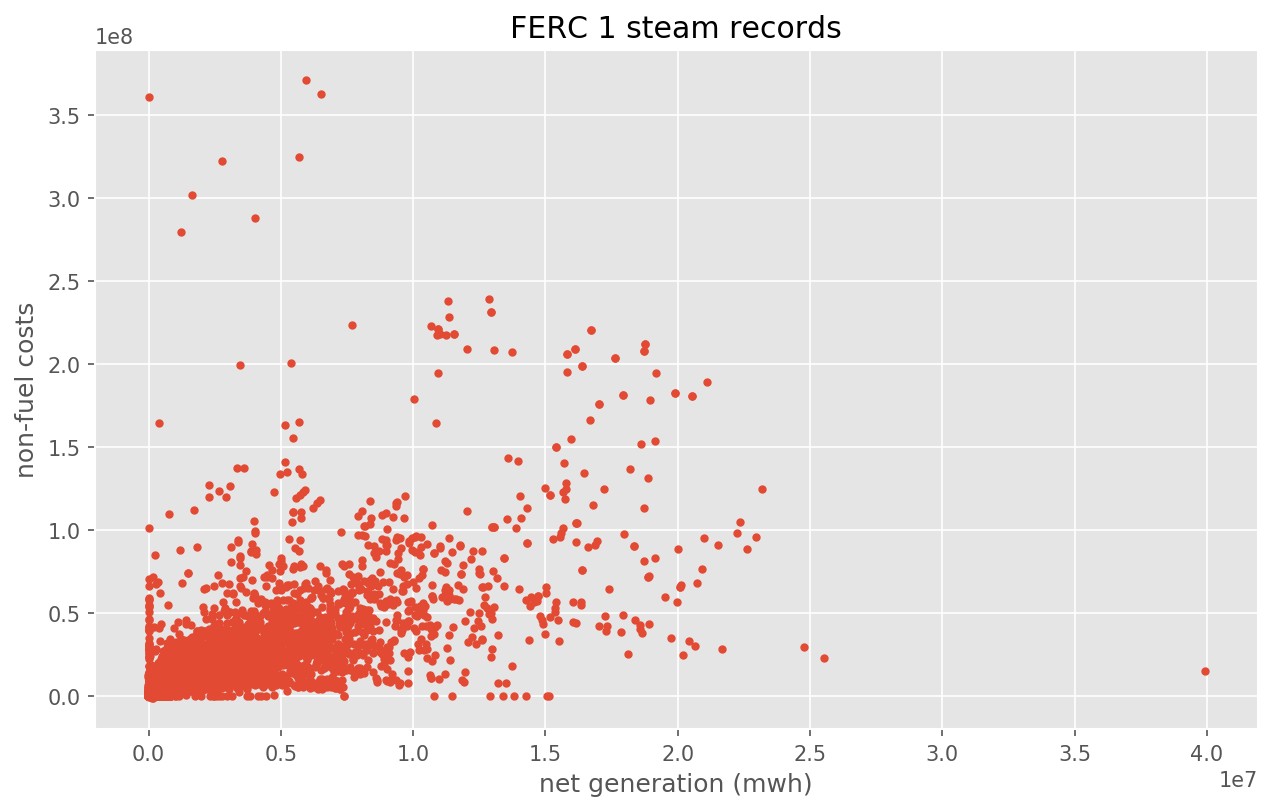

In [44]:
plt.plot(x,y,'.')
plt.title('FERC 1 steam records')
plt.xlabel('net generation (mwh)')
plt.ylabel('non-fuel costs')

In [45]:
### Exploration of other approaches...

In [46]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state=0)

In [47]:
x_train= x_train.values.reshape(-1, 1)
y_train= y_train.values.reshape(-1, 1)
x_test = x_test.values.reshape(-1, 1)

In [48]:
ridge = Ridge(fit_intercept=True, alpha=0.5)

In [49]:
ridge.fit(x_reshape,y_reshape)

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [50]:
sklearn.linear_model.Ridge(alpha=1.0, fit_intercept=True, normalize=False, copy_X=True, max_iter=None, tol=0.001, solver='auto', random_state=None)
# ferc1_training_steam.net_generation_mwh, ferc1_training_steam.non_fuel_costs)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [51]:
clf = sklearn.linear_model.Ridge(alpha=1)
clf = sklearn.linear_model.Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False, random_state=None, solver='auto', tol=0.001)

clf.fit(x_reshape, y_reshape)
# Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [52]:
result = clf.fit(x_reshape, y_reshape, sample_weight=None)

In [53]:
clf.score(x_reshape,y_reshape)

0.5170931615709048

In [54]:
result.get_params()

{'alpha': 1,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}